In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import random
from sklearn.metrics import f1_score
from datetime import datetime
today = datetime.today().strftime("%m%d")

from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import albumentations
import albumentations.pytorch

In [2]:
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'

In [3]:
df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(train_dir, 'images')

In [4]:
# Training settings
batch_size = 32
epochs = 50
lr = 0.00003
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
class MaskDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.df = pd.read_csv(os.path.join(img_paths, 'train.csv'))
        self.img_paths = self.find_path(self.df, os.path.join(img_paths, 'images'))
        self.transform = transform
    
    def find_path(self, df,image_dir):
        file_path = []
        for img_path in df.path:
            for img in os.listdir(os.path.join(image_dir, img_path)):
                if (img.split('.')[0] != '') and (img.split('.')[-1] != 'ipynb_checkpoints'):
                    file_path.append(os.path.join(image_dir, img_path, img))
        return file_path
    
    def make_label(self,img_paths):
        gender = img_paths.split('/')[-2].split('_')[1]
        age = int(img_paths.split('/')[-2].split('_')[-1])

        if img_paths.split('/')[-1].split('.')[0] not in ['incorrect_mask','normal']:
            wear = 'mask'
        else:
            wear = img_paths.split('/')[-1].split('.')[0]

        gender_class = 0 if gender=='male' else 1
        age_class = int(age/30)
        if wear=='mask':
            wear_class = 0
        elif wear=='incorrect_mask':
            wear_class = 1
        else:
            wear_class = 2

        return 6*wear_class + 3*gender_class + age_class
    
    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
    
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        label = self.make_label(self.img_paths[index])
        
        if self.transform:
            image = self.transform(image=np.array(image))
            
        return image, label

    def __len__(self):
        return len(self.img_paths)

In [7]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.55800916, 0.51224077, 0.47767341), std=(0.21817792, 0.23804603, 0.25183411)):

    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

In [8]:
transform = get_transforms()

dataset = MaskDataset(train_dir, get_transforms())
lengths = [int(len(dataset)*0.8), int(len(dataset)*0.2)]
train_set, val_set = torch.utils.data.random_split(dataset, lengths,generator=torch.Generator().manual_seed(seed))

train_set.dataset.set_transform(transform['train'])
val_set.dataset.set_transform(transform['val'])

In [9]:
train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    num_workers=4,
    shuffle=True
)
valid_loader = DataLoader(
    val_set,
    batch_size = batch_size,
    num_workers=4,
    shuffle=False
)

In [10]:
from matplotlib import pyplot as plt

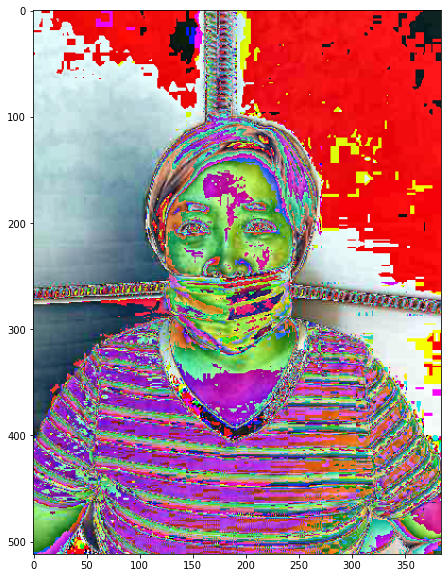

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(torchvision.transforms.ToPILImage()(dataset[0][0]['image']))
plt.show()

## Models

In [11]:
device = 'cuda'

In [12]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b3", advprop=True, num_classes=18).to(device)

Loaded pretrained weights for efficientnet-b3


## Train

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [15]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
lrs = []

In [21]:
path = f'/opt/ml/code/model/{today+"_"+model.__class__.__name__}'
if not os.path.exists(path):
    os.makedirs(path)

In [1]:
best_val_loss = 9999
best_val_f1 = 0
NUM_ACCUM = 4


for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_f1 = 0
    
    for i, data in enumerate(tqdm(train_loader,leave=True)):
        model.train()
        inputs, label = data
        inputs = inputs['image'].to(device)
        label = label.to(device)

        output = model(inputs)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        
#         if i % NUM_ACCUM == 0:
        optimizer.step()

            
        acc = (output.argmax(dim=1) == label).float().mean()

        epoch_accuracy += acc / len(train_loader)
        epoch_f1 += f1_score(output.argmax(dim=1).cpu(), label.cpu(), average='macro') / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    # lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()

    with torch.no_grad():
        model.eval()
        epoch_val_accuracy = 0
        epoch_val_f1 = 0
        epoch_val_loss = 0
        
        for val_batch in valid_loader:
            inputs, label = val_batch
            inputs = inputs['image'].to(device)
            label = label.to(device)

            val_output = model(inputs)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_f1 += f1_score(val_output.argmax(dim=1).cpu(), label.cpu(), average='macro') / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    

            
    if epoch_val_loss < best_val_loss:
        print("New best model for val loss! saving the model..")
        torch.save(model.state_dict(), os.path.join(f'{path}/{epoch:03}_loss_{epoch_val_loss:4.2}.pt'))
        best_val_loss = epoch_val_loss


    if epoch_val_f1 > best_val_f1:
        print("New best model for val f1! saving the model..")
        torch.save(model.state_dict(), os.path.join(f'{path}/{epoch:03}_f1_{epoch_val_f1:4.2}.pt'))
        best_val_f1 = epoch_val_f1
        best_model = f'{path}/{epoch:03}_f1_{epoch_val_f1:4.2}.pt'
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - f1: {epoch_f1:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - val_f1: {epoch_val_f1:.4f}\n"
    )

KeyboardInterrupt: 

In [24]:
# 모델의 파라메터를 저장
torch.save(model.state_dict(), os.path.join('/opt/ml/code/model', "model_0826_1_EffB3.pt"))
# 모델의 architecture와 함께 저장
torch.save(model, os.path.join('/opt/ml/code/model', "model_0826_1_EffB3_full.pt"))

{3e-05}

In [23]:
model = EfficientNet.from_pretrained("efficientnet-b3", advprop=True, num_classes=18).to(device)
model.load_state_dict(torch.load(best_model))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

In [24]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform
        
    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
    
    
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image=np.array(image))
        return image

    def __len__(self):
        return len(self.img_paths)

In [25]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform)
dataset.set_transform(transform['val'])
loader = DataLoader(
    dataset,
    shuffle=False
)

In [26]:
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')

model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images['image'].to(device)
        pred = model(images.float())
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission_0827_EffB3_cencrop_rancrop.csv'), index=False)
print('test inference is done!')


test inference is done!


In [27]:
submission.ans.value_counts()

0     2367
1     2319
4     1721
3     1499
2      735
13     522
7      510
6      471
12     468
10     344
5      343
16     326
15     309
9      303
8      122
14     111
17      66
11      64
Name: ans, dtype: int64

**모델의 파라메터를 저장**

torch.save(model.state_dict(), os.path.join(MODEL_PATH, "model.pt"))

**모델의 architecture와 함께 저장**

torch.save(model, os.path.join(MODEL_PATH, "model.pt"))

**같은 모델의 형태에서 파라메터만**

new_model = TheModelClass()

new_model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "model.pt")))

**모델의 architecture와 함께 load**

model = torch.load(os.path.join(MODEL_PATH, "model.pt"))